In [4]:
import numpy as np
import sys
sys.path.append('.')
import matplotlib.pyplot as plt
%matplotlib notebook

## 추론기반 기법과 신경망 

### 통계기반 기법의 문제점

### 추론 기반 기법의 개요

### 신경망에서의 단어 처리

In [2]:
c = np.array([[1,0,0,0,0,0,0]])
W = np.random.randn(7,3)
h = np.matmul(c,W)
print(h)

[[-0.1787107  -0.61393417  0.61581048]]


In [11]:
sys.path.append('deep2')
from deep2.common.layers import MatMul

c = np.array([[1,0,0,0,0,0,0]])
W = np.random.randn(7,3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[-0.62184722  0.34157711  0.76767894]]


## 단순한  word2vec
- CBOW model

### CBOW model의 추론처리 

In [12]:
c0 = np.array([[1,0,0,0,0,0,0]])
c1 = np.array([[0,0,1,0,0,0,0]])
# 가중치 초기화
W_in = np.random.randn(7,3)
W_out = np.random.randn(3,7)

in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = (h1+h0)/2
s = out_layer.forward(h)

print(s)

[[-0.09341411  0.39231173  0.94942082  0.0059469  -1.13547956 -0.09084152
  -1.25646368]]


### CBOW  모델의 학습
- 다중 레이블 분류 : 소프트맥스와 크로스 엔트로피 오차를 이용

### word2vec의 가중치와 분산표현
- 입력 가중치와 출력 가중치를 이용하여 단어의 분산 표현
- 주로 입력 가중치만을 이용한 방법을 선호

## 학습데이터 준비

### 맥락과 타깃

In [14]:
# 말뭉치를 단어 ID로 변환
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus, word_to_id)

[0 1 2 3 4 1 5 6] {'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}


In [15]:
# 맥락과 타깃 만들기
# 맥락 : 앞뒤 1단어

def create_contexts_target(corpus, window_size = 1):
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size,len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size+1):
            if t==0:
                continue
            cs.append(corpus[idx+t])
        contexts.append(cs)
    
    return np.array(contexts), np.array(target)

In [25]:
contexts, target = create_contexts_target(corpus,window_size=1)

print(contexts,'\n',target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]] 
 [1 2 3 4 1 5]


### 원핫 표현으로 변환

In [27]:
from common.util import convert_one_hot

vocab_size = len(word_to_id)
target = convert_one_hot(target,vocab_size)
contexts = convert_one_hot(contexts,vocab_size)

## CBOW model 구현

In [32]:
from common.layers import SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self,vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        W_in = 0.01 * np.random.randn(V,H).astype('f')
        W_out = 0.01 * np.random.randn(H,V).astype('f')
        
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        layers = [self.in_layer0,self.in_layer1,self.out_layer]
        self.params,self.grads = [],[]
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        self.word_vec = W_in
    
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:,0])
        h1 = self.in_layer1.forward(contexts[:,1])
        h = (h1 + h0)/2
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score)
        return loss
    
    def backward(self,dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

### 학습코드 구현

In [34]:
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot
from deep2.ch03.simple_cbow import SimpleCBOW

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus,window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)
trainer.fit(contexts,target,max_epoch,batch_size)
trainer.plot

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

| 에폭 274 |  반복 1 / 2 | 시간 0[s] | 손실 1.05
| 에폭 275 |  반복 1 / 2 | 시간 0[s] | 손실 1.05
| 에폭 276 |  반복 1 / 2 | 시간 0[s] | 손실 1.03
| 에폭 277 |  반복 1 / 2 | 시간 0[s] | 손실 1.12
| 에폭 278 |  반복 1 / 2 | 시간 0[s] | 손실 0.96
| 에폭 279 |  반복 1 / 2 | 시간 0[s] | 손실 1.12
| 에폭 280 |  반복 1 / 2 | 시간 0[s] | 손실 0.96
| 에폭 281 |  반복 1 / 2 | 시간 0[s] | 손실 1.03
| 에폭 282 |  반복 1 / 2 | 시간 0[s] | 손실 0.96
| 에폭 283 |  반복 1 / 2 | 시간 0[s] | 손실 1.01
| 에폭 284 |  반복 1 / 2 | 시간 0[s] | 손실 1.03
| 에폭 285 |  반복 1 / 2 | 시간 0[s] | 손실 1.10
| 에폭 286 |  반복 1 / 2 | 시간 0[s] | 손실 1.11
| 에폭 287 |  반복 1 / 2 | 시간 0[s] | 손실 1.02
| 에폭 288 |  반복 1 / 2 | 시간 0[s] | 손실 0.94
| 에폭 289 |  반복 1 / 2 | 시간 0[s] | 손실 0.94
| 에폭 290 |  반복 1 / 2 | 시간 0[s] | 손실 1.17
| 에폭 291 |  반복 1 / 2 | 시간 0[s] | 손실 1.01
| 에폭 292 |  반복 1 / 2 | 시간 0[s] | 손실 0.94
| 에폭 293 |  반복 1 / 2 | 시간 0[s] | 손실 1.00
| 에폭 294 |  반복 1 / 2 | 시간 0[s] | 손실 1.01
| 에폭 295 |  반복 1 / 2 | 시간 0[s] | 손실 1.10
| 에폭 296 |  반복 1 / 2 | 시간 0[s] | 손실 1.00
| 에폭 297 |  반복 1 / 2 | 시간 0[s] | 손실 1.00
| 에폭 298 |  반복 1

| 에폭 554 |  반복 1 / 2 | 시간 0[s] | 손실 0.81
| 에폭 555 |  반복 1 / 2 | 시간 0[s] | 손실 0.86
| 에폭 556 |  반복 1 / 2 | 시간 0[s] | 손실 0.64
| 에폭 557 |  반복 1 / 2 | 시간 0[s] | 손실 0.81
| 에폭 558 |  반복 1 / 2 | 시간 0[s] | 손실 0.67
| 에폭 559 |  반복 1 / 2 | 시간 0[s] | 손실 0.70
| 에폭 560 |  반복 1 / 2 | 시간 0[s] | 손실 0.67
| 에폭 561 |  반복 1 / 2 | 시간 0[s] | 손실 0.77
| 에폭 562 |  반복 1 / 2 | 시간 0[s] | 손실 0.81
| 에폭 563 |  반복 1 / 2 | 시간 0[s] | 손실 0.64
| 에폭 564 |  반복 1 / 2 | 시간 0[s] | 손실 0.67
| 에폭 565 |  반복 1 / 2 | 시간 0[s] | 손실 0.77
| 에폭 566 |  반복 1 / 2 | 시간 0[s] | 손실 0.81
| 에폭 567 |  반복 1 / 2 | 시간 0[s] | 손실 0.71
| 에폭 568 |  반복 1 / 2 | 시간 0[s] | 손실 0.59
| 에폭 569 |  반복 1 / 2 | 시간 0[s] | 손실 0.78
| 에폭 570 |  반복 1 / 2 | 시간 0[s] | 손실 0.66
| 에폭 571 |  반복 1 / 2 | 시간 0[s] | 손실 0.86
| 에폭 572 |  반복 1 / 2 | 시간 0[s] | 손실 0.58
| 에폭 573 |  반복 1 / 2 | 시간 0[s] | 손실 0.77
| 에폭 574 |  반복 1 / 2 | 시간 0[s] | 손실 0.65
| 에폭 575 |  반복 1 / 2 | 시간 0[s] | 손실 0.85
| 에폭 576 |  반복 1 / 2 | 시간 0[s] | 손실 0.58
| 에폭 577 |  반복 1 / 2 | 시간 0[s] | 손실 0.72
| 에폭 578 |  반복 1

| 에폭 842 |  반복 1 / 2 | 시간 0[s] | 손실 0.65
| 에폭 843 |  반복 1 / 2 | 시간 0[s] | 손실 0.76
| 에폭 844 |  반복 1 / 2 | 시간 0[s] | 손실 0.69
| 에폭 845 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 846 |  반복 1 / 2 | 시간 0[s] | 손실 0.51
| 에폭 847 |  반복 1 / 2 | 시간 0[s] | 손실 0.72
| 에폭 848 |  반복 1 / 2 | 시간 0[s] | 손실 0.65
| 에폭 849 |  반복 1 / 2 | 시간 0[s] | 손실 0.54
| 에폭 850 |  반복 1 / 2 | 시간 0[s] | 손실 0.79
| 에폭 851 |  반복 1 / 2 | 시간 0[s] | 손실 0.54
| 에폭 852 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 853 |  반복 1 / 2 | 시간 0[s] | 손실 0.44
| 에폭 854 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 855 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 856 |  반복 1 / 2 | 시간 0[s] | 손실 0.79
| 에폭 857 |  반복 1 / 2 | 시간 0[s] | 손실 0.54
| 에폭 858 |  반복 1 / 2 | 시간 0[s] | 손실 0.51
| 에폭 859 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 860 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 861 |  반복 1 / 2 | 시간 0[s] | 손실 0.54
| 에폭 862 |  반복 1 / 2 | 시간 0[s] | 손실 0.79
| 에폭 863 |  반복 1 / 2 | 시간 0[s] | 손실 0.50
| 에폭 864 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 865 |  반복 1 / 2 | 시간 0[s] | 손실 0.65
| 에폭 866 |  반복 1

<bound method Trainer.plot of <common.trainer.Trainer object at 0x000000BE61DBA948>>

<IPython.core.display.Javascript object>


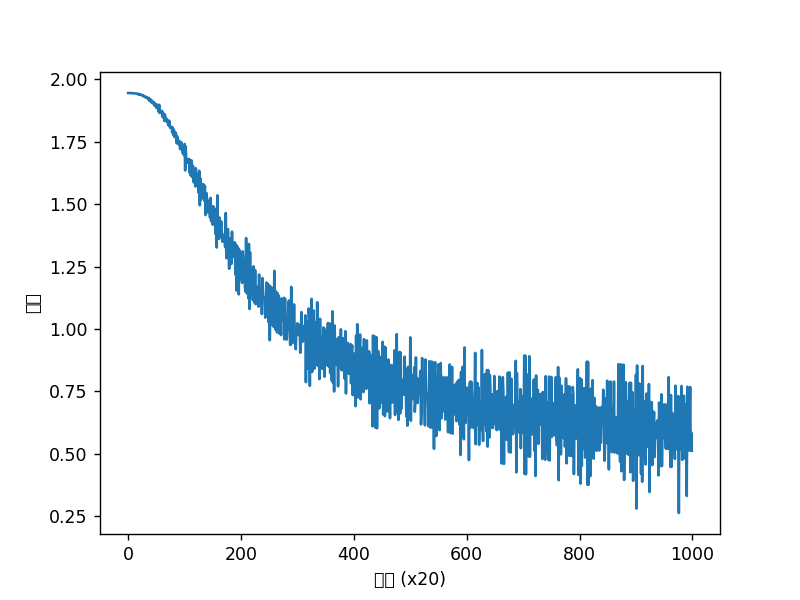

In [35]:
trainer.plot()

In [37]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [ 1.071279  -1.1146808 -1.1365385  1.146036  -1.2664669]
say [-1.2169654   1.2028615   1.2304868  -1.1583083   0.20864086]
goodbye [ 0.8307932  -0.781134   -0.70461935  0.74076486 -0.7146486 ]
and [-1.0577537   0.9911525   1.0420412  -0.84163314  1.893606  ]
i [ 0.8547305  -0.7761963  -0.7422238   0.74908537 -0.7085217 ]
hello [ 1.0654972 -1.1038952 -1.1436542  1.1566031 -1.2764503]
. [-1.016058   1.0818086  1.0495903 -1.1801548 -1.7151294]
